## 1-D Fokker-Plank Equation

 Parameter inference is based on calculating the first two Kramers-Moyal coefficients, as explained in detail in Appendix A of https://doi.org/10.1103/PhysRevX.11.031022 

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime
import os

In [2]:
name_data = "sample_trajectories.pkl"

# Generate sample trajectories


This code generates sample trajectories of various lengths, which are used by the example notebook                                   "Parameter inference via Kramers-Moyal coefficients.ipynb" to demonstrate parameter inference via Kramers-Moyal coefficients.


In [3]:
os.makedirs("data")

Fn =  os.path.join(os.getcwd(),"data",name_data)

# initialize random number generator
rng = np.random.default_rng()

# Set simulation parameters
dt = 1e-5 # timestep for simulation
dt_out = 1e-4 # timestep of saved trajectories
stride_out = int(np.round(dt_out/dt))
N_sim = 4000 # number of trajectories to be generated

# For each trajectory, we use a random number of timesteps. This is to
# show that the parameter inference works with trajectory samples of
# various lengths.
# The number of timesteps for each trajectory is sampled from a uniform
# distribution on the interes from N_steps_min to N_steps_max, which are
# defined here:
N_steps_mean = int(np.round(0.05/dt))
N_steps_min = N_steps_mean*0.5
N_steps_max = N_steps_mean*1.5
# generate an array that contains the number of steps of all trajectories:
N_steps = rng.integers(low=N_steps_min,
                        high=N_steps_max,
                        size=N_sim)

# For each simulation, the initial condition is drawn from a uniform
# distribution on [x_L, x_R], using the following values:
x_L = -1.5
x_R = 1.5

# Definition of the parameters of the Langevin equation.
#
# We simulate the Ito-Langevin equation
#          dX_t = a(X_t) * dt  +  sqrt(2*D) * dW_t,
# where dX_t is the increment of the reaction coordinate at time t,
# a(x) is the drift, D is the diffusivity (which we assume to be a constant
# number, meaning we consider additive noise), and dW_t is the increment
# of the Wiener process.
#
# We consider a constant diffusivity
D = 1.
# and a gradient drift a(x) = -dU/dx that originates from a double-well potential
# U(x) = U0 * ( x**2 - 1 )**2, so that a(x) = -4 * U0 * ( x**2 - 1 ) * x.
U0 = 2.
a = lambda x: -4*U0*(x**2 - 1)*x


trajectories = []
print("{time}\tStarting simulation of {total} trajectories...".format(
                total =N_sim,
            time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
for i in range(N_sim):
    print("{time}\tRunning simulation {cur_int} of {total}...".format(cur_int=i+1,
                    total =N_sim,
                time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
                end='\r')
    #
    # generate array containing current trajectory
    current_trajectory = np.zeros(N_steps[i]+1,dtype=float)
    # generate initial condition for current trajectory
    current_trajectory[0] = rng.random()*(x_R-x_L) + x_L
    #
    # generate all random numbers for the current simulation
    random_numbers_for_current_simulation = rng.normal(size=N_steps[i])
    random_numbers_for_current_simulation *= np.sqrt(2*D*dt)
    #
    # run simulation using Euler-Maruyama algorithm
    for j,current_x in enumerate(current_trajectory[:-1]):
        current_trajectory[j+1] = dt*a(current_x) \
                            + random_numbers_for_current_simulation[j] \
                            + current_x
    #
    # append current trajectory to list of trajectories
    trajectories.append(current_trajectory[::stride_out])

print("{time}\tFinished simulation {total} trajectories.              ".format(
                total =N_sim,
            time=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),
            end='\n')

# save resulting trajectories
pickle.dump(trajectories,open(Fn,'wb'))


2024-02-05 21:19:53	Starting simulation of 4000 trajectories...
2024-02-05 21:20:22	Finished simulation 4000 trajectories.              


# Utility functions

In [4]:
import numpy as np
import pickle

class inference:
	'''
	This is the base class that contains the shared codebase for both the
	linear and nonlinear integrators
	'''
	def __init__(self,parameters={}):
		'''
		Set simulation parameters, which are provided
		as dictionary in the argument parameters
		'''
		#
		self.trajectories_loaded = False
		self.index_loaded = False
		#
		self.verbose = True # default value for verbose
		self.index_directory = './' # default value for index directory
		#
		# the following parameters need to be set by the user
		self.trajectories_filename = 'not set'
		self.xl = -np.inf
		self.xr = +np.inf
		self.N_bins = 100
		self.dt = 'not set'
		# the following two parameters are calculated by the program
		# and cannot be set manually
		self.dx = 'not set'
		self.x = 'not set'
		#
		self.set_parameters(parameters)

	def set_parameters(self,parameters={}):
		'''
		Change parameters of an existing instance of this class
		'''
		#
		try:
			self.verbose = parameters['verbose']
		except KeyError:
			pass
		#
		try:
			self.trajectories_filename = parameters['trajectories_filename']
		except KeyError:
			pass
		#
		try:
			self.index_directory = parameters['index_directory']
		except KeyError:
			pass
		#
		try:
			self.xl = parameters['xl']
		except KeyError:
			pass
		#
		try:
			self.xr = parameters['xr']
		except KeyError:
			pass
		#
		try:
			self.N_bins = parameters['N_bins']
		except KeyError:
			pass
		#
		try:
			self.dt = parameters['dt']
		except KeyError:
			pass
		#
		# update arrays
		#
		if self.xl > -np.inf and self.xr < np.inf:
			self.dx = (self.xr - self.xl)/self.N_bins
			if self.N_bins != 'not set':
				self.x = self.xl + (np.arange(self.N_bins) + 0.5)*self.dx

	def get_parameters(self,print_parameters=False):
		'''
		Return current parameters
		'''
		self.index_parameters = {
				'trajectories_filename':self.trajectories_filename,
				'index_directory':self.index_directory,
				'xl':self.xl,
		          'xr':self.xr,
		          'dx':self.dx,
		          'dt':self.dt,
		          'N_bins':self.N_bins,
		          'x':self.x
				  }
		if print_parameters:
			print("Parameters set for this instance:")
			print("trajectories_filename = {0}".format(
						self.trajectories_filename))
			print("index_directory       = {0}".format(
					self.index_directory))
			print("xl        = {0}".format(self.xl))
			print("xr        = {0}".format(self.xr))
			print("dx        = {0}".format(self.dx))
			print("dt        = {0}".format(self.dt))
			print("N_bins    = {0}".format(self.N_bins))
		return self.index_parameters

	def save_parameters(self):
		'''
		Save current parameters
		'''
		#
		pickle.dump( self.get_parameters(print_parameters=False),
						open( self.index_directory + "/index_parameters.pkl", "wb" ) )

	def load_parameters(self):
		'''
		Load saved parameters
		'''
		#
		index_parameters = pickle.load(
						open( self.index_directory + "/index_parameters.pkl", "rb" ) )
		self.set_parameters(index_parameters)

	def check_if_all_parameters_are_set(self):
		'''
		Check if all the parameters necessary for inference are set
		'''
		#
		if self.trajectories_filename == 'not set':
			raise RuntimeError("Filename for input trajectories not set.")
		#
		if self.dt == 'not set':
			raise RuntimeError("Timestep not set.")

	def load_trajectories(self):
		#
		self.trajectory_lengths = []
		#
		if self.trajectories_filename == 'not set':
			raise RuntimeError("No filename for trajectories to load "\
						+ "provided.")
		#
		self.trajectories = pickle.load(open(f"./data/{self.trajectories_filename}", "rb"))
		#
		for i, current_trajectory in enumerate(self.trajectories):
			self.trajectory_lengths.append(len(current_trajectory))
		if self.verbose:
			print("Loaded {0} trajectories.".format(len(self.trajectories)))
		#
		self.trajectories_loaded = True
		#
		self.get_range_of_time_series()
		self.check_bounds_of_spatial_domain()

	def import_trajectories(self,trajectories):
		#
		self.trajectories = []
		self.trajectory_lengths = []
		#
		for i, current_trajectory in enumerate(trajectories):
			self.trajectories.append(current_trajectory)
			self.trajectory_lengths.append(len(current_trajectory))
		#
		if self.verbose:
			print("Imported {0} trajectories.".format(len(self.trajectories)))
		#
		self.trajectories_loaded = True
		#
		self.get_range_of_time_series()
		self.check_bounds_of_spatial_domain()

	def get_range_of_time_series(self):
		#
		if self.trajectories_loaded == False:
			raise RuntimeError("Please load trajectories first.")
		#
		max_pos = -np.inf
		min_pos = np.inf
		for i, current_trajectory in enumerate(self.trajectories):
			cur_max = np.max(current_trajectory)
			cur_min = np.min(current_trajectory)
			if cur_max > max_pos:
				max_pos = cur_max
			if cur_min < min_pos:
				min_pos = cur_min
		'''
		if self.verbose:
			print("For currently loaded trajectories, minimal and maximal "\
			+ "positions are {0:3.5f} and {1:3.5f}".format(min_pos,max_pos))
		''';
		self.min_pos = min_pos
		self.max_pos = max_pos

	def check_bounds_of_spatial_domain(self):
		#
		if self.xl < self.min_pos:
			if self.xl != -np.inf:
				print("Warning: l0 < (minimal position in dataset), i.e." \
					+ " {0:3.5f} < {1:3.5f}.".format(self.xl,self.min_pos) \
					+ "\n\tUsing l0 = {0:3.5f}".format(self.min_pos))
			self.xl = self.min_pos
		#
		if self.xr > self.max_pos:
			if self.xr != np.inf:
				print("Warning: r0 > (maximal position in dataset), i.e." \
					+ " {0:3.5f} > {1:3.5f}.".format(self.xr,self.max_pos) \
					+ "\n\tUsing r0 = {0:3.5f}".format(self.max_pos))
			self.xr = self.max_pos
		# update parameters so that dx gets calculated again if
		# self.xl or self.xr have changed
		self.set_parameters()

	def get_histogram(self,N_hist=100):
		#
		bin_edges = np.linspace(self.xl,self.xr,
									endpoint=True,
									num=N_hist+1,
									dtype=float)
		bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
		dx_bins = bin_edges[1] - bin_edges[0]
		hist = np.zeros(N_hist,dtype=float)
		#
		for i, current_trajectory in enumerate(self.trajectories):
			#
			bin_numbers = (current_trajectory - bin_edges[0]) // dx_bins
			for j in range(N_hist):
				hist[j] += np.sum( bin_numbers == j )
		#
		return hist, bin_edges


	def create_index(self):
		#
		# check that trajectories are loaded
		if self.trajectories_loaded == False:
			raise RuntimeError("Please load trajectories first.")
		#
		#
		# traj_number:    enumerates the trajectories we consider
		# traj_index:     enumerates the timestep within each trajectory
		# traj_bin_index: contains the bin index of the current position of the current trajectory
		#
		self.traj_number = np.array([],dtype=int)
		self.traj_index = np.array([],dtype=int)
		self.traj_bin_index = np.array([],dtype=int)
		#
		update_frequency = np.max([len(self.trajectories) // 100,1])
		#
		for i,current_trajectory in enumerate(self.trajectories):
			if self.verbose:
				if i % update_frequency == 0:
					print('Creating index. '\
							+ 'Processing trajectory {0} of {1}..'.format(
								i+1,len(self.trajectories)
									),end='\r')
			current_indices = np.array((current_trajectory-self.xl)//self.dx,
										dtype=int)
			#
			# number of current trajectory
			self.traj_number = np.append(self.traj_number,
										np.ones(len(current_indices))*i)
			# positions within current trajectory
			self.traj_index = np.append(self.traj_index,
										np.arange(len(current_indices)))
			# index of bins
			self.traj_bin_index = np.append(self.traj_bin_index,
										current_indices)
			#
		self.traj_bin_indices = []
		for i in range(self.N_bins):
			self.traj_bin_indices.append(
						np.array(np.where(self.traj_bin_index == i)[0],dtype=int)
										)
		#
		self.traj_number = self.traj_number.astype(int)
		self.traj_index = self.traj_index.astype(int)
		#
		self.index_loaded = True
		#
		if self.verbose:
			print('Finished creating index. Processed {0} trajectories. '.format(
						len(self.trajectories)
							),end='\n')
		#
		#return traj_number ,traj_index, traj_bin_indices

	def save_index(self):
		#
		if self.index_loaded == False:
			raise RuntimeError("No index loaded, so no index can be saved.")
		#
		self.save_parameters()
		#
		pickle.dump( self.traj_number,
						open( self.index_directory + "/index_traj_number.pkl", "wb" ) )
		pickle.dump( self.traj_index,
						open( self.index_directory + "/index.pkl", "wb" ) )
		pickle.dump( self.traj_bin_indices,
						open( self.index_directory + "/index_bin_indices.pkl", "wb" ) )
		#

	def load_index(self):
		#
		self.load_parameters()
		#
		self.traj_number = pickle.load(
						open( self.index_directory + "/index_traj_number.pkl", "rb" ) )
		self.traj_index = pickle.load(
						open( self.index_directory + "/index.pkl", "rb" ) )
		self.traj_bin_indices = pickle.load(
						open( self.index_directory + "/index_bin_indices.pkl", "rb" ) )
		#

	def run_inference(self,N_shift=1):
		#
		D_array = np.zeros(self.N_bins,dtype=float)
		a_array = np.zeros(self.N_bins,dtype=float)
		#
		for i in range(self.N_bins):
			if self.verbose:
				print('Running inference. Processing bin {0} of {1}..'.format(
								i+1,self.N_bins),end='\r')
			D_array[i], a_array[i] = self.kramers_moyal_single_bin(
									bin_index=i,
									N_shift=N_shift)
		if self.verbose:
			print('Finished inference with {0} bins.                   '.format(
											self.N_bins),end='\n')
		#
		output_dictionary = {'x':self.x,
							'D':D_array,
							'a':a_array}
		return output_dictionary

	def kramers_moyal_single_bin(self,
								bin_index,N_shift):
		# get list of trajectories starting in given bin
		list_of_trajectories_starting_in_bin = self.traj_bin_indices[bin_index]
		N = len(list_of_trajectories_starting_in_bin)
		# set up variables for <x>, <x^2>, which we want to estimate from data
		delta_x = 0.
		delta_x_squared = 0.
		# iterate through all trajectories that start in bin
		for i,cur_index in enumerate(list_of_trajectories_starting_in_bin):
			# note that traj_index[cur_index] labels the time at which the trajectory
			# with number traj_number[cur_index] is in the bin of interest.
			#
			if (self.traj_index[cur_index]+N_shift) >= \
				self.trajectory_lengths[self.traj_number[cur_index]]:
				# this means that the length of the current trajectory segment
				# is less than the lagtime we want to use. In that case we
				# skip the current trajectory segment, but since we now have
				# one datapoint less we need to subtract 1 from N
				N -= 1
				continue
			#
			cur_diff = self.trajectories[self.traj_number[cur_index]]   \
								[self.traj_index[cur_index]+N_shift]   \
					- self.trajectories[self.traj_number[cur_index]]   \
										[self.traj_index[cur_index]]
			#
			delta_x += cur_diff
			delta_x_squared += cur_diff**2
		#
		if N == 0:
			print('Warning: Encountered a bin with N = 0 datapoints. To avoid '\
				+ 'this issue, please i) change the interval size [xl,xr], '\
				+ 'ii) decrease N_shift, or iii) use longer '\
				+ 'trajectories.')
			return np.nan, np.nan
		#
		D = delta_x_squared /(2*N*self.dt*N_shift)
		drift = delta_x / (N*self.dt*N_shift)
		#
		return D, drift


# Analyze data

In [5]:
# the pickle file should contain a list of 1D arrays, i.e. 
trajectories = pickle.load(open(f"./data/{name_data}", "rb"))
# must lead to an object "trajectories" such that
#     trajectories[i] = 1D array
# for i = 0, ..., len(trajectories)

In [6]:
print("number of elements: ", len(trajectories))
print("one element: ", trajectories[0].shape, "first column:", trajectories[0][0])

number of elements:  4000
one element:  (568,) first column: 0.9548044960342428


In [7]:
# directory where the index we create will be saved:
index_directory = './' 

# timestep of the trajectories
dt = 1e-4

# create a dictionary with the parameters
parameters = {'index_directory':index_directory,
            'trajectories_filename':name_data,
            'dt':dt}

# create an instance of the kramers_moyal class
inference = inference(parameters)

In [8]:
# parameters of an existing class can be changed by creating a dictionary
# with the new parameters, and by passing that dictionary to the class:
N_bins = 120
updated_parameters = {'N_bins':N_bins}

inference.set_parameters(updated_parameters)
inference.get_parameters()

{'trajectories_filename': 'sample_trajectories.pkl',
 'index_directory': './',
 'xl': -inf,
 'xr': inf,
 'dx': 'not set',
 'dt': 0.0001,
 'N_bins': 120,
 'x': 'not set'}

In [9]:
inference

In [10]:
inference.get_parameters()

{'trajectories_filename': 'sample_trajectories.pkl',
 'index_directory': './',
 'xl': -inf,
 'xr': inf,
 'dx': 'not set',
 'dt': 0.0001,
 'N_bins': 120,
 'x': 'not set'}

In [11]:
# parameters of an existing class can be changed by creating a dictionary
# with the new parameters, and by passing that dictionary to the class:
N_bins = 120
updated_parameters = {'N_bins':N_bins}

inference.set_parameters(updated_parameters)
inference.get_parameters()

{'trajectories_filename': 'sample_trajectories.pkl',
 'index_directory': './',
 'xl': -inf,
 'xr': inf,
 'dx': 'not set',
 'dt': 0.0001,
 'N_bins': 120,
 'x': 'not set'}

In [12]:
# the trajectories are loaded from the pickle file stored in the class variable "trajectories_filename"
inference.load_trajectories()

# instead of loading a pickle file, already loaded trajectories can alternatively be imported, via:
#
# preloaded_trajectories = [ list of 1D arrays with trajectories ]
# inference.import_trajectories(preloaded_trajectories)

# Note that only one list of trajectories can be loaded at one time. If several datasets are to be used, 
# they should be merged before passing them to the inference class.

Loaded 4000 trajectories.


In [13]:
# after loading trajectories, the class variables 
# xl, xr, dx, x 
# are automatically updated:
inference.get_parameters()

{'trajectories_filename': 'sample_trajectories.pkl',
 'index_directory': './',
 'xl': -1.7234120312191301,
 'xr': 1.7199104709515158,
 'dx': 0.02869435418475538,
 'dt': 0.0001,
 'N_bins': 120,
 'x': array([-1.70906485, -1.6803705 , -1.65167615, -1.62298179, -1.59428744,
        -1.56559308, -1.53689873, -1.50820437, -1.47951002, -1.45081567,
        -1.42212131, -1.39342696, -1.3647326 , -1.33603825, -1.3073439 ,
        -1.27864954, -1.24995519, -1.22126083, -1.19256648, -1.16387212,
        -1.13517777, -1.10648342, -1.07778906, -1.04909471, -1.02040035,
        -0.991706  , -0.96301165, -0.93431729, -0.90562294, -0.87692858,
        -0.84823423, -0.81953987, -0.79084552, -0.76215117, -0.73345681,
        -0.70476246, -0.6760681 , -0.64737375, -0.6186794 , -0.58998504,
        -0.56129069, -0.53259633, -0.50390198, -0.47520762, -0.44651327,
        -0.41781892, -0.38912456, -0.36043021, -0.33173585, -0.3030415 ,
        -0.27434714, -0.24565279, -0.21695844, -0.18826408, -0.15956973,

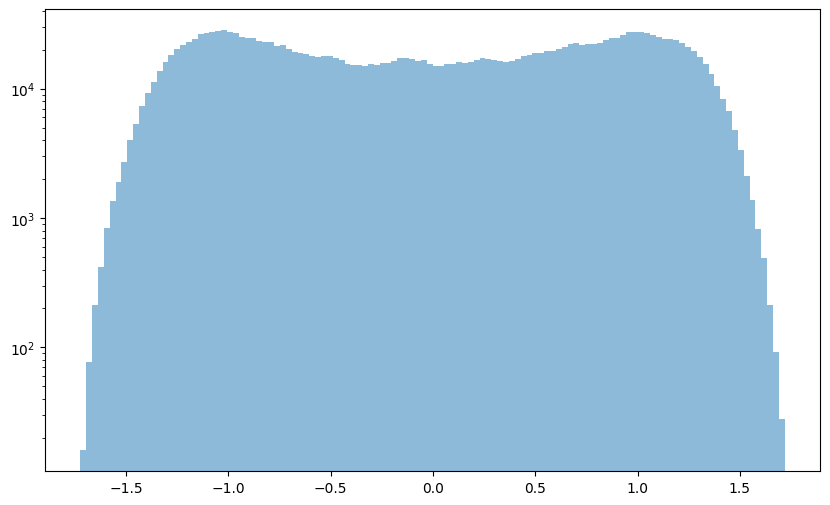

In [14]:
# to see how many datapoints are available within each bin, we create 
# a histogram of the loaded data:

N_hist = N_bins # we use the same number of bins as for the inference
hist, bin_edges = inference.get_histogram(N_hist=N_hist)

bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bar_width = bin_centers[1] - bin_centers[0]

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,width=bar_width,
      alpha=0.5)
ax.set_yscale('log')
plt.show()
plt.close(fig)


In [15]:
inference.create_index()

Finished creating index. Processed 4000 trajectories. 


In [16]:
inference.save_index()

In [17]:
# delete instance of class
del inference

In [18]:
# create new instance of the class, which needs to know where we store the index files, 
# and where we store the trajectories

parameters = {'index_directory':index_directory,
            'trajectories_filename':name_data}

inference = inference(parameters=parameters)
inference.load_trajectories()
inference.load_index()

# upon loading the index, all parameters from the previous instance are recovered:
inference.get_parameters()

NameError: name 'inference' is not defined

# Run inference and plot results
With the trajectories and the index loaded into the class instance, we can finally run the inference:

In [ ]:
# if the inference is run without an argument, the value N_shift = 1 is used
inference_result = inference.run_inference() # = inference.run_inference(N_shift=1)

# the call returns a dictionary with the bin centers x, as well as the 
# inferred diffusivity and drift at those bin centers:
x = inference_result['x']
D = inference_result['D']
a = inference_result['a']

Finished inference with 120 bins.                   


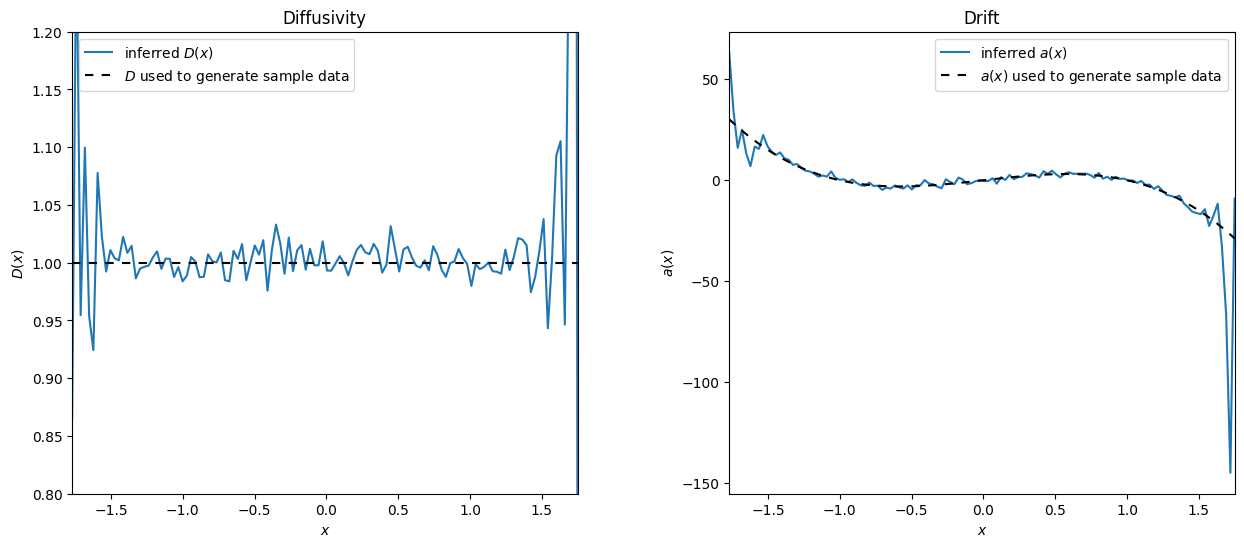

In [ ]:
# we plot the results, and compare them to the input D and a(x) used for 
# generating the sample data:

fig,axes = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.set_title('Diffusivity')
ax.plot(x,D,
       label=r'inferred $D(x)$')
ax.axhline(1.,
        dashes=[4,4],
           label='$D$ used to generate sample data',
          color='black')
ax.set_ylim(0.8,1.2)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$D(x)$')

ax = axes[1]
ax.set_title('Drift')
ax.plot(x,a,
        label=r'inferred $a(x)$')
ax.plot(x,-4*2*(x**2-1)*x,
        dashes=[4,4],
           label=r'$a(x)$ used to generate sample data',
       color='black')
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$a(x)$')

plt.show()
plt.close(fig)

In [ ]:
N_shifts = [1,10,50,100]

inference_results = []

for i,N_shift in enumerate(N_shifts):
    print("Running inference for N_shift = {0}".format(N_shift))
    inference_result = inference.run_inference(N_shift=N_shift)
    inference_results.append(inference_result)

Running inference for N_shift = 1
Finished inference with 120 bins.                   
Running inference for N_shift = 10
Finished inference with 120 bins.                   
Running inference for N_shift = 50
Finished inference with 120 bins.                   
Running inference for N_shift = 100


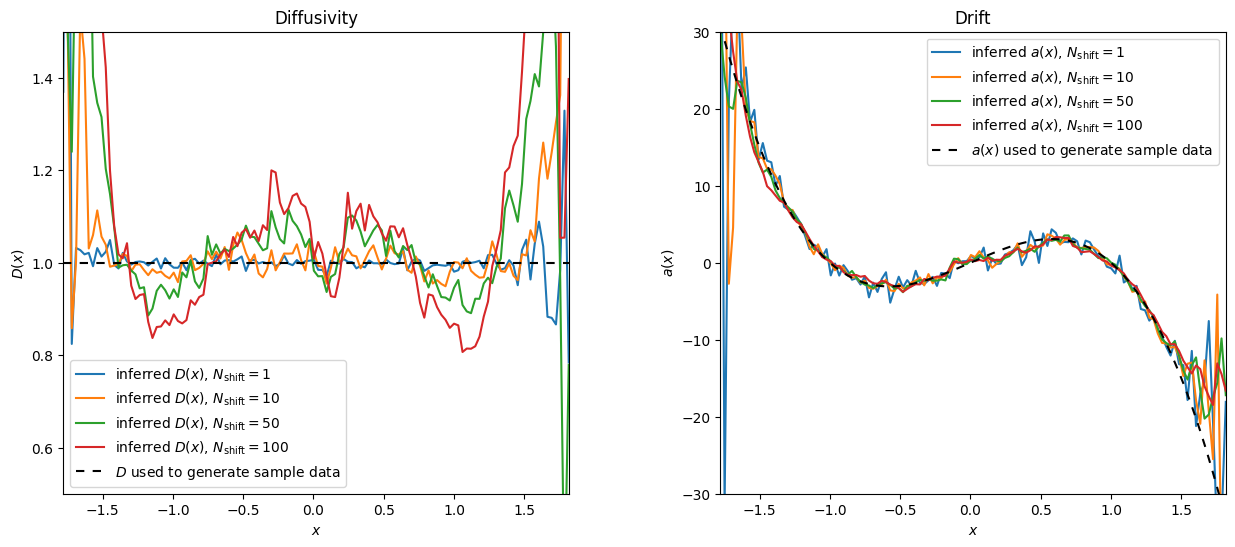

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(wspace=0.3)

for i, inference_result in enumerate(inference_results):
    x = inference_result['x']
    D = inference_result['D']
    a = inference_result['a']
    #
    axes[0].plot(x,D,
       label=r'inferred $D(x)$, $N_{\mathrm{shift}} = $' + '{0}'.format(N_shifts[i]))
    axes[1].plot(x,a,
        label=r'inferred $a(x)$, $N_{\mathrm{shift}} = $' + '{0}'.format(N_shifts[i]))

ax = axes[0]
ax.set_title('Diffusivity')
ax.axhline(1.,
        dashes=[4,4],
           label='$D$ used to generate sample data',
          color='black')
ax.set_ylim(0.5,1.5)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$D(x)$')

ax = axes[1]
ax.set_title('Drift')
ax.plot(x,-4*2*(x**2-1)*x,
        dashes=[4,4],
           label=r'$a(x)$ used to generate sample data',
       color='black')
ax.set_ylim(-30,30)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$a(x)$')

plt.show()
plt.close(fig)


# References

https://github.com/juliankappler/fokker-planck